# **1. Kết nối với google drive**

In [ ]:
# kết nối với gg drive
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/NLP 4+1/BTL3- BERT and GPT/pre-trained/')
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/.shortcut-targets-by-id/1bs2wermM-w1hKEOcHyv-UmLHY5iag5cm/NLP 4+1/BTL3- BERT and GPT/pre-trained'

# **2. Install và import các thư viện cần thiết**

In [ ]:
!pip install transformers --quiet
!pip install keras_preprocessing --quiet

In [ ]:
import os
import re
import time
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import load_model
from keras_preprocessing.sequence import pad_sequences
from transformers import GPT2LMHeadModel, BertLMHeadModel

import nltk
nltk.download('punkt')

from nltk import word_tokenize
from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu, corpus_bleu

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **3. Set các biến cục bộ và load dữ liệu**

In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    text = text.lower()
    text = decontractions(text)
    text = re.sub(r'[!“”"’#$%&\()*+,./:;<=>?@[\]^_`{|}~]', "", text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# saving
def save_file(data, path):
    with open(path + '.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
def load_file(path):
    with open(path, 'rb') as handle:
        data = pickle.load(handle)
    return data

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# **4. Load pre-trained cho các model**

## ***4.1 Model GPT***

In [ ]:
tokenizer_GPT = load_file('./GPT/tokenizer.pickle')
model_GPT = load_file('./GPT/GPT2LMHeadModel.pickle')

In [ ]:
model_GPT.resize_token_embeddings(len(tokenizer_GPT))
model_GPT = model_GPT.to(device)
if device == 'cpu':
    model_GPT.load_state_dict(torch.load('./GPT/model_GPT.pt', map_location ='cpu'))
else:
    model_GPT.load_state_dict(torch.load('./GPT/model_GPT.pt'))

In [ ]:
def GPT_answer(inp, tokenizer=tokenizer_GPT, model=model_GPT):
    inp = '<s> '+ preprocess(inp) +" <bot>: "
    inp = tokenizer(inp, return_tensors="pt")
    X = inp["input_ids"].to(device)
    mask = inp["attention_mask"].to(device)
    output = model.generate(X, attention_mask=mask, max_length=96, pad_token_id=0, eos_token_id=50256)
    output = tokenizer.decode(output[0])
    try:
        result = re.search(r'<bot>:(.*?)</s>', output).group(1).strip()
    except:
        result = re.search(r'<bot>:\s*(.*)', output).group(1).strip()
    return result

In [ ]:
GPT_answer("do i need to exercise to benefit from vitamin c")

'no vitamin c is absorbed without exercise but do not get me wrong exercise is very desirable on its own certainly not exercise is not required to increase absorption of nutrients'

## ***4.2 Model BERT***

In [ ]:
tokenizer_BERT = load_file('./BERT/tokenizer.pickle')
model_BERT = load_file('./BERT/BertLMHeadModel.pickle')

In [ ]:
model_BERT = model_BERT.to(device)
if device == 'cpu':
    model_BERT.load_state_dict(torch.load('./BERT/model_BERT.pt', map_location ='cpu'))
else:
    model_BERT.load_state_dict(torch.load('./BERT/model_BERT.pt'))

In [ ]:
def BERT_answer(inp, tokenizer=tokenizer_BERT, model=model_BERT):
    inputs = tokenizer(preprocess(inp), max_length=120, padding='max_length', return_tensors="pt").to(device)
    outputs = model(**inputs, labels=inputs["input_ids"])

    result = []
    for word_embeds in outputs.logits[0]:
        word_embed = word_embeds
        max_idx_t = word_embed.argmax()
        max_idx = max_idx_t.item()
        word = tokenizer.convert_ids_to_tokens(max_idx)
        if word == '[PAD]' or word == '[SEP]': 
            break
        result.append(word)
    return ' '.join(result)

In [ ]:
BERT_answer('do i need to exercise to benefit from vitamin c')

'no vitamin c is absorbed without exercise but do not get me wrong wrong'

## ***4.3 Model LSTM***

In [ ]:
# LSTM (100 epoch)
tokenizer_LSTM_100 = load_file( './LSTM (100 epoch)/tokenizer.pickle')
enc_model_LSTM_100 = load_model('./LSTM (100 epoch)/enc_model.h5')
dec_model_LSTM_100 = load_model('./LSTM (100 epoch)/dec_model.h5')

# LSTM (200 epoch)
tokenizer_LSTM_200 = load_file( './LSTM (200 epoch)/tokenizer.pickle')
enc_model_LSTM_200 = load_model('./LSTM (200 epoch)/enc_model.h5')
dec_model_LSTM_200 = load_model('./LSTM (200 epoch)/dec_model.h5')

# LSTM + Attention (100 epoch)
tokenizer_LSTM_Attention_100 = load_file( './LSTM + Attention (100 epoch)/tokenizer.pickle')
enc_model_LSTM_Attention_100 = load_model('./LSTM + Attention (100 epoch)/enc_model.h5')
dec_model_LSTM_Attention_100 = load_model('./LSTM + Attention (100 epoch)/dec_model.h5')

# LSTM + Attention (200 epoch)
tokenizer_LSTM_Attention_200 = load_file( './LSTM + Attention (200 epoch)/tokenizer.pickle')
enc_model_LSTM_Attention_200 = load_model('./LSTM + Attention (200 epoch)/enc_model.h5')
dec_model_LSTM_Attention_200 = load_model('./LSTM + Attention (200 epoch)/dec_model.h5')

In [ ]:
MAXLEN_QUESTION = 32
MAXLEN_ANSWER = 64
def str_to_tokens(sentence, tokenizer):
    words = preprocess(sentence)
    tokens_list = tokenizer.texts_to_sequences([words])
    return pad_sequences(tokens_list, maxlen=MAXLEN_QUESTION,padding='post')
    
def LSTM_answer(question, with_epochs):
    if with_epochs == 100:
        tokenizer, enc_model, dec_model = tokenizer_LSTM_100, enc_model_LSTM_100, dec_model_LSTM_100
    elif with_epochs == 200:
        tokenizer, enc_model, dec_model = tokenizer_LSTM_200, enc_model_LSTM_200, dec_model_LSTM_200
    else:
        return 'Sai with_epoch rồi'

    states_values = enc_model.predict(str_to_tokens(question, tokenizer), verbose=0)
    empty_target_seq = np.zeros((1,1))
    empty_target_seq[0,0] = tokenizer.word_index['<s>']
    stop_condition = False
    generated_answer = ''
    while not stop_condition:
        dec_outputs, h, c = dec_model.predict([empty_target_seq]+states_values, verbose=0)
        sampled_word_index = np.argmax(dec_outputs[0,-1, :])
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != '</s>':
                    generated_answer += f'{word} '
                sampled_word = word

        if sampled_word == '</s>' or len(generated_answer.split()) > MAXLEN_ANSWER:
            stop_condition = True
        empty_target_seq = np.zeros((1,1))
        empty_target_seq[0,0] = sampled_word_index
        states_values = [h,c]

    return generated_answer.strip()

def LSTM_Attention_answer(question, with_epochs):
    if with_epochs == 100:
        tokenizer, enc_model, dec_model = tokenizer_LSTM_Attention_100, enc_model_LSTM_Attention_100, dec_model_LSTM_Attention_100
    elif with_epochs == 200:
        tokenizer, enc_model, dec_model = tokenizer_LSTM_Attention_200, enc_model_LSTM_Attention_200, dec_model_LSTM_Attention_200
    else:
        return 'Sai with_epoch rồi'

    values,h,c = enc_model.predict(str_to_tokens(question, tokenizer), verbose=0)
    empty_target_seq = np.zeros((1,1))
    empty_target_seq[0,0] = tokenizer.word_index['<s>']
    stop_condition = False
    generated_answer = ''

    while not stop_condition:
        dec_outputs, h_state,c_state = dec_model.predict([empty_target_seq]+[values,h,c], verbose=0)
        sampled_word_index = np.argmax(dec_outputs[0,-1, :])
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_word_index == index:
                if word != '</s>':
                    generated_answer += f'{word} '
                sampled_word = word

        if sampled_word == '</s>' or len(generated_answer.split()) > MAXLEN_ANSWER:
            stop_condition = True
        empty_target_seq = np.zeros((1,1))
        empty_target_seq[0,0] = sampled_word_index
        h,c = h_state,c_state

    return generated_answer.strip()

print('LSTM (100 epochs):', LSTM_answer('do i need to exercise to benefit from vitamin c', with_epochs=100))
print('LSTM (200 epochs):', LSTM_answer('do i need to exercise to benefit from vitamin c', with_epochs=200))
print('LSTM + Attention (100 epochs):', LSTM_Attention_answer('do i need to exercise to benefit from vitamin c', with_epochs=100))
print('LSTM + Attention (200 epochs):', LSTM_Attention_answer('do i need to exercise to benefit from vitamin c', with_epochs=200))

LSTM (100 epochs): no
LSTM (200 epochs): no vitamin c is absorbed without exercise but do not take any of the year you should be fine
LSTM + Attention (100 epochs): certainly not exercise is not required to increase absorption of vitamin c
LSTM + Attention (200 epochs): no vitamin


# **5. Đánh giá model**

Để đánh giá model ở đây nhóm em sẽ đánh giá dự trên các tiêu chí
* ***đồ thị loss***: giá trị loss thu được từ quá trình huấn luyện
* ***time_train*** : thời gian huấn luyện
* ***time_test*** : thời gian dự đoán (model trả lời các câu hỏi)
* ***blue_score***: Điểm BLEU được tính bằng cách đếm số lượng mã thông báo đơn lẻ hoặc tiếp theo được chia sẻ giữa chuỗi được tạo và tham chiếu. N mã thông báo tiếp theo được gọi là “n-gram”. Unigram đề cập đến một mã thông báo duy nhất trong khi bi-gram đề cập đến các cặp mã thông báo và n-gram đề cập đến n mã thông báo tiếp theo. *Điểm nằm trong khoảng từ 0 đến 1, trong đó 1 có nghĩa là bản dịch hoàn toàn khớp và 0 hoàn toàn không khớp*

## ***5.1 Load dữ liệu đánh giá***

In [ ]:
df_test = pd.read_csv('../dataset/test.csv')
df_test

,question,answer
0,how do you get rid of birthmarks naturally min...,there are no natural ways to get rid of birth ...
1,is there some non prescription meds for a nebu...,no other than normal saline
2,i have bile salt diarrhea after gallbladder su...,after i had my gallbladder surgery i went thro...
3,how much of an impact does vitamin d have on d...,there have been studies suggesting that high d...
4,why are some people not infected by a virus ev...,hi its because there carriers and being a carr...
...,...,...
95,can i get pregnant if i have sex 2 days after ...,the short answer is yes it is possible if your...
96,can hpv sprwad through sharing drinks cigarett...,no hpv human papilloma virus is spread through...
97,i have severe left flank pain but was told not...,pancreatic problems can cause left flank pain ...
98,if i am feeling really hungry after exercising...,i have a protein shake which relieves me of th...


In [ ]:
# tạo các list chứa tên nhằm map với các function đã tạo nhằm để dự đoán
name_fun = ['LSTM_100', 'LSTM_200', 'LSTM_Attention_100', 'LSTM_Attention_200', 'BERT', 'GPT']
name_idx_model = ['LSTM (100 epoch)', 'LSTM (200 epoch)', 'LSTM + Attention (100 epoch)', 'LSTM + Attention (200 epoch)', 'BERT', 'GPT']

In [ ]:
# load dữ liệu thu được từ quá trình training (loss, time_train)
compare = {}
for name_model in name_idx_model:
    val_compare = load_file(f'./{name_model}/val_compare.pickle')
    compare[name_model] = val_compare

## ***5.2 Xây dựng hàm để đánh giá các model***

In [ ]:
def evaluation_model(df, name_model):
    # bot answer
    t0 = time.time()
    if name_model == 'LSTM_100':
        df['bot_answer'] = df['question'].apply(lambda inp: LSTM_answer(inp, with_epochs=100))
    elif name_model == 'LSTM_200':
        df['bot_answer'] = df['question'].apply(lambda inp: LSTM_answer(inp, with_epochs=200))
    elif name_model == 'LSTM_Attention_100':
        df['bot_answer'] = df['question'].apply(lambda inp: LSTM_Attention_answer(inp, with_epochs=100))
    elif name_model == 'LSTM_Attention_200':
        df['bot_answer'] = df['question'].apply(lambda inp: LSTM_Attention_answer(inp, with_epochs=200))
    elif name_model == 'BERT':
        df['bot_answer'] = df['question'].apply(lambda inp: BERT_answer(inp))
    elif name_model == 'GPT':
        df['bot_answer'] = df['question'].apply(lambda inp: GPT_answer(inp))
    time_test = time.time() - t0
   
    # compute blue_score
    df['blue_score'] = df.apply(lambda row: sentence_bleu([word_tokenize(row['answer'])],
                                                          word_tokenize(row['bot_answer']),
                                                          weights=(0.333, 0.333, 0.334),
                                                          smoothing_function=SmoothingFunction().method1), axis=1)
    average_blue_score = df['blue_score'].sum()/len(df)
    
    return  time_test, average_blue_score

In [ ]:
# bot answer for evaluation
for i in range(len(name_fun)):
    print(name_fun[i])
    time_test, blue_score = evaluation_model(df_test, name_fun[i])
    compare[name_idx_model[i]]['time_test'] = time_test
    compare[name_idx_model[i]]['blue_score'] = blue_score

LSTM_100
LSTM_200
LSTM_Attention_100
LSTM_Attention_200
BERT
GPT


## ***5.3 Biểu đồ thể hiện loss của các model trong quá trình training***

In [ ]:
df_compare = pd.DataFrame(compare).T
df_compare

,loss_history,time_train,time_test,blue_score
LSTM (100 epoch),"[6.922053813934326, 6.552059173583984, 6.52201...",3164.008015,263.282011,0.049576
LSTM (200 epoch),"[6.905888080596924, 6.547808647155762, 6.51895...",6295.781462,227.514925,0.047819
LSTM + Attention (100 epoch),"[6.867033004760742, 6.392114639282227, 6.16835...",3191.378547,289.081974,0.049547
LSTM + Attention (200 epoch),"[6.877901554107666, 6.399126052856445, 6.17264...",6690.13742,253.262887,0.055349
BERT,"[3.261120916629324, 2.6469188928604126, 2.5798...",15328.067309,1.570166,0.031839
GPT,"[4.97974168402808, 2.3210640944996657, 1.91642...",17541.465786,88.565114,0.086988


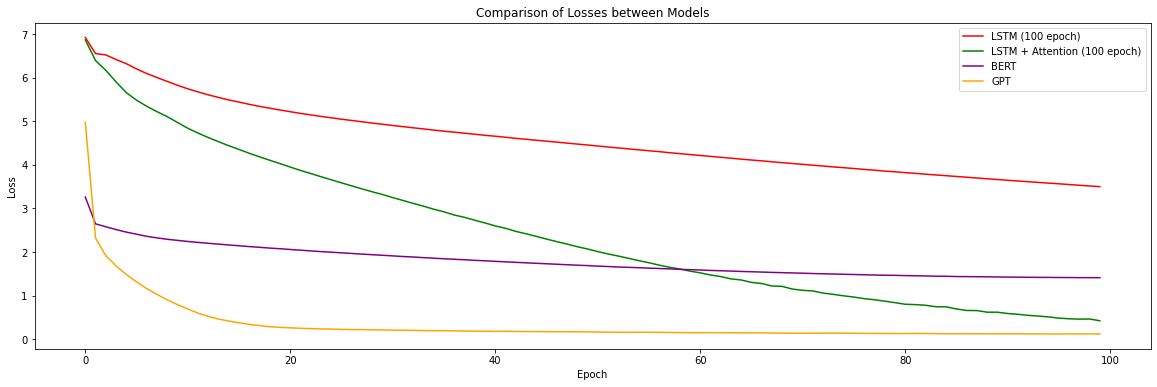

In [ ]:
plt.figure(figsize=(20,6))
# Tạo một list chứa các màu sắc để sử dụng cho từng model
colors = ["red", "blue", "green", "brown", "purple", "orange"]

# Vẽ đồ thị loss cho mỗi model
for i, model_name in enumerate(df_compare.index):
    if '200' not in model_name:
        loss_history = df_compare.loc[model_name, "loss_history"]
        epochs = len(loss_history)
        plt.plot(np.arange(epochs), loss_history, label=model_name, color=colors[i])

# Thiết lập các thông số cho đồ thị
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparison of Losses between Models")
plt.legend()

# Hiển thị đồ thị
plt.show()

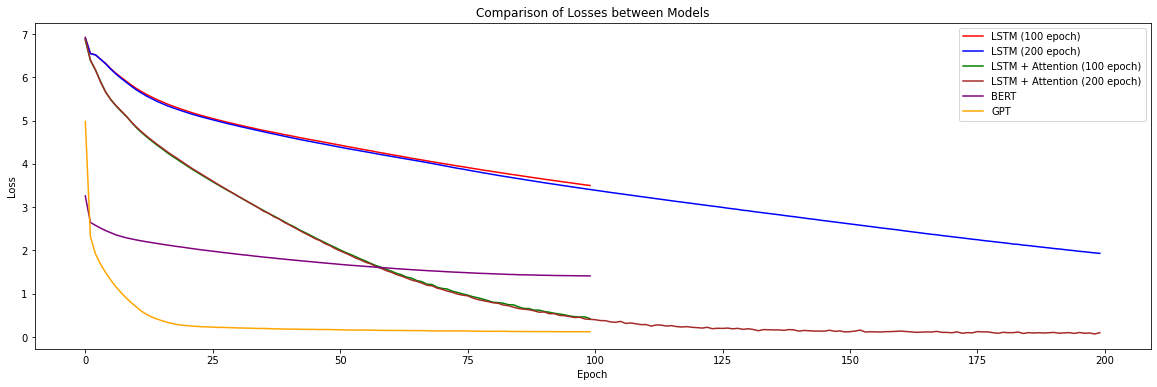

In [ ]:
plt.figure(figsize=(20,6))
# Tạo một list chứa các màu sắc để sử dụng cho từng model
colors = ["red", "blue", "green", "brown", "purple", "orange"]

# Vẽ đồ thị loss cho mỗi model
for i, model_name in enumerate(df_compare.index):
    loss_history = df_compare.loc[model_name, "loss_history"]
    epochs = len(loss_history)
    plt.plot(np.arange(epochs), loss_history, label=model_name, color=colors[i])

# Thiết lập các thông số cho đồ thị
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Comparison of Losses between Models")
plt.legend()

# Hiển thị đồ thị
plt.show()

## ***5.4 Biểu đồ so sánh các độ đo khác (time_train, time_test, blue_score)***

In [ ]:
df_compare = df_compare.drop(['loss_history'], axis=1)
df_compare.style.highlight_max(color = 'green', axis = 0, subset=['blue_score']
                ).highlight_min(color = 'red', axis = 0, subset=['time_train','time_test'])

,time_train,time_test,blue_score
LSTM (100 epoch),3164.008015,263.282011,0.049576
LSTM (200 epoch),6295.781462,227.514925,0.047819
LSTM + Attention (100 epoch),3191.378547,289.081974,0.049547
LSTM + Attention (200 epoch),6690.137420,253.262887,0.055349
BERT,15328.067309,1.570166,0.031839
GPT,17541.465786,88.565114,0.086988


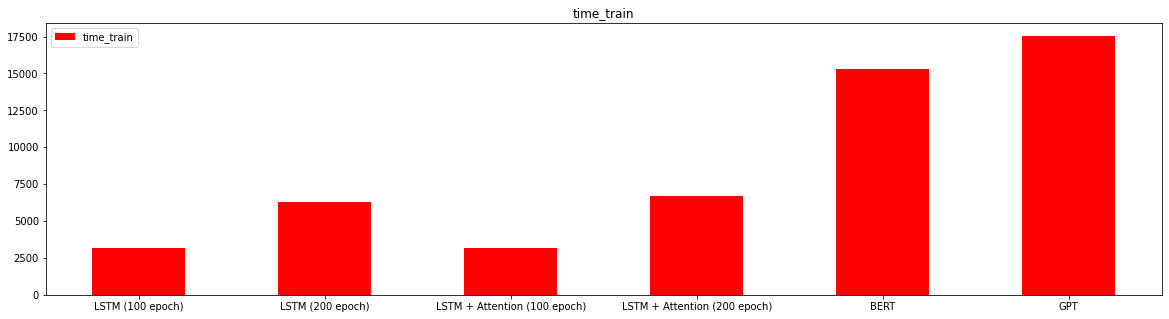

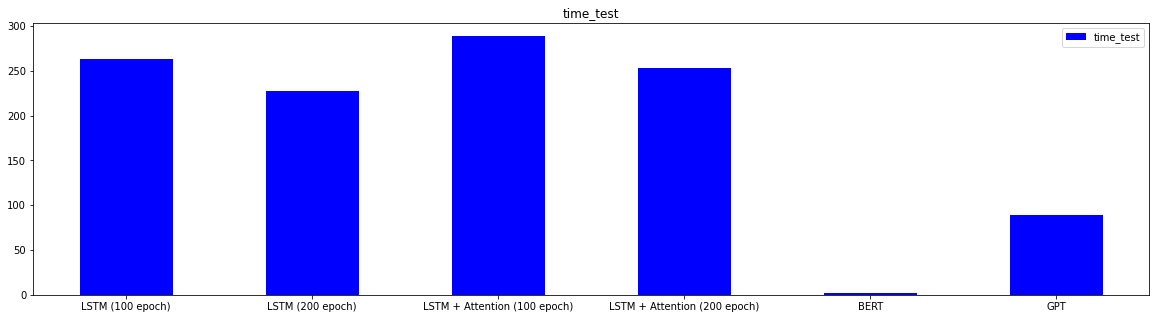

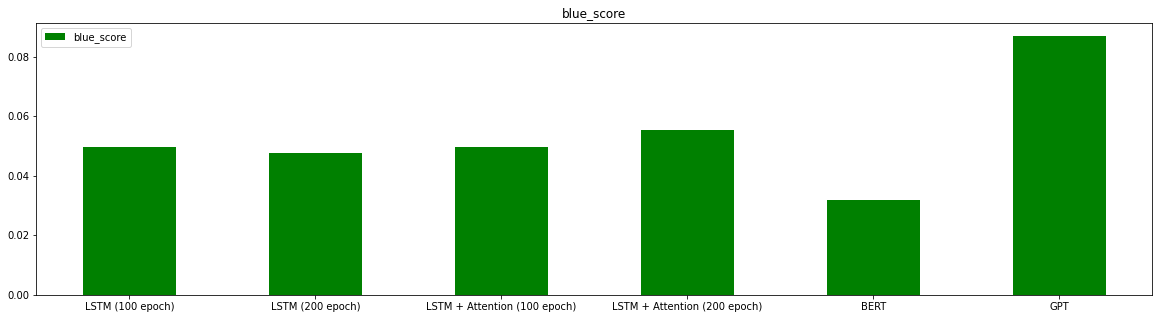

In [ ]:
for i, col in enumerate(df_compare.columns):
    df_compare.plot(kind= 'bar', y=col, title=col, rot=0, figsize=(20,5), color=colors[i])

# **6. Show answer**

In [ ]:
def show_bot_answer(i):
    question = df_test.iloc[i]['question']
    actual_answer = df_test.iloc[i]['answer']

    print('question                :', question)
    print('actual answer           :', actual_answer)
    print('(LSTM 100)              :', LSTM_answer(question, with_epochs=100)) 
    print('(LSTM 200)              :', LSTM_answer(question, with_epochs=200))
    print('(LSTM + Attention 100)  :', LSTM_Attention_answer(question, with_epochs=100)) 
    print('(LSTM + Attention 200)  :', LSTM_Attention_answer(question, with_epochs=200)) 
    print('(BERT)                  :', BERT_answer(question)) 
    print('(GPT)                   :', GPT_answer(question)) 

In [ ]:
show_bot_answer(1)

question                : is there some non prescription meds for a nebulizer to help clear my lungs
actual answer           : no other than normal saline
(LSTM 100)              : the best thing is to take a week or two two medications you should be fine
(LSTM 200)              : there are many effective antibiotics that are safe to take together
(LSTM + Attention 100)  : there are an antibiotic based on your own weight would treat it if you have concerns about them the medication handles your doctor would be do you know about what type of chemotherapy or chemotherapy
(LSTM + Attention 200)  : most helpful answer neither hi in the world that is the correct dosage to help you excess for a few few minutes before an hour in both for instance if you are having any condition called pitocin oxytocin that a mega decrease of acid can be added to help relieve the size of the the right dose at daily routine to help exercise exercise
(BERT)                  : no are are used used type specific c

In [ ]:
show_bot_answer(7)

question                : can a women get pregnant from precum pre ejaculation and if she doesnt have an orgasim
actual answer           : yes a woman can get pregnant from pre ejaculation it contains sperm if a woman is ovulating it is possible to get pregnant in this situation with or without an orgasm
(LSTM 100)              : hi yes it is possible to get a test done in a few days good luck
(LSTM 200)              : yes you can get pregnant from anytime of the month you are having difficulty if you are pregnant or not not you need to take a pregnancy test as a generic version and it will not be used in pregnancy the reason for the specific drug screen and the only way you are taking and you should talk to your doctor and get a test
(LSTM + Attention 100)  : hi the answer the end and it in your vagina this can be from two hours to understand this it would be the best way to see your doctor or gyno and a phantom help with case your find help good luck
(LSTM + Attention 200)  : yes you

In [ ]:
show_bot_answer(9)

question                : i am the only family member who got a flu shot and i have the flu and they do not what could explain this
actual answer           : most helpful answer every person is different the flu shot is not 100 protective many of my patients who got the flu vaccine this year developed a mutating strain of the flu and influenza is often misdiagnosed so did you have a lab test to prove you have influenza
(LSTM 100)              : i do not know what type of your particular case it is not a good idea to do it
(LSTM 200)              : i have had a problem i was told my dr was was told from my doctor for a test done there was a lot of getting pregnant is that you can get pregnant and when the egg is not required to do
(LSTM + Attention 100)  : per the question that was three to my health below and your women went in the area of the last
(LSTM + Attention 200)  : per the question below the doctor took a nasal swab the result said i had influenza type a
(BERT)                

In [ ]:
show_bot_answer(10)

question                : if you lose your employee health insurance after the dec 15 deadline can you enroll at any time or do you have to wait until another enrollment period comes around
actual answer           : losing existing coverage is considered a qualifying event and that allows you to sign up for insurance even if it is outside the open enrollment period
(LSTM 100)              : if you are pregnant or have had a period of course there is a possibility that you can be properly examined diagnosed and treated
(LSTM 200)              : if you are not using a secondary form of birth control your first year old
(LSTM + Attention 100)  : hi ok if you shop on your saturday till of your plan you will go if you will need to wait no good luck
(LSTM + Attention 200)  : i am not sure but the plans you are using on the marketplace is marketplace on your semen injection is considered grandfathered meaning it comes to shop for 60 depends on your own your first nope month test would be fine

In [ ]:
show_bot_answer(11)

question                : can ear plugs cause ear infections
actual answer           : yes external ear canal infections otitis externa swimmer is ear can be caused by ear plugs but not middle ear infections
(LSTM 100)              : no the two medications are compatible
(LSTM 200)              : not really but but a lot of them yes i do not know the medical history of your particular case it would be best to see your medical provider to determine the reason
(LSTM + Attention 100)  : a coincidence blood rash can dry ended the leg so it can be a reoccurence tougher itis because the rubbing in boiling medieval can cause a warming sensation more serious kidney infection like acylovir blodd and washing your larynx resulting in pernicious good blood pressure hope you want
(LSTM + Attention 200)  : yes staph bacteria can formation with a sore throat this can result in a minor membrane injury to themselves to the paranasal sinuses an infection
(BERT)                  : yes ear ear ear can ear